In [1]:
import sys
sys.path.append('./../../designer/script/')
sys.path.append('./../')
sys.path.append('./../../')

import pickle
import copy

import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import matplotlib.patches as mpatches
import numpy as np

import film as film_mod
import design as design_mod
import spectrum as spec_mod
from analyze_utils.structure import plot_layer_thickness, diff_simple_film
from analyze_utils.result_io import load
from analyze_utils.make_design import make_reflection_design
from utils.loss import calculate_RMS_f_spec, calculate_RMS
from utils.get_n import get_n_SiO2, get_n_TiO2
from utils.loss import calculate_RMS_f_spec
from optimizer.adam import AdamThicknessOptimizer


## Different OT - Bragg structure

In [2]:
working_file = './back_reflector_result_thickness_optimize'

loss_rep_ls, film_rep_ls, target_design: design_mod.BaseDesign = load(working_file)
target = target_design.target_specs[0]

def color():
    i = 0
    while True:
        yield f'C{i}'
        i += 1
c_gen = color()

In [11]:
# Process loss_rep (thickness GD)
# loss_rep_arr = np.array([[l[-1] for l in rep] for rep in loss_rep_ls])
loss_rep_arr = np.array([[min(losses) for losses in losses_ls] for losses_ls in loss_rep_ls])


In [54]:
# analyze helpers

def calculate_dif_Bragg(film: film_mod.TwoMaterialFilm, dA, dB):
    # NOTE: film keeps the material of the first layer in remove negative layers.
    # The first layer is SiO2.
    # make Bragg film
    film_gt = film.get_d().sum()
    n = int(film_gt // (dA + dB))
    ext = film_gt - n * (dA + dB)

    film_Bragg_1 = film_mod.TwoMaterialFilm(
        'SiO2', 
        'TiO2', 
        'SiO2', 
        np.array([[dA, dB][i % 2] for i in range(2 * n)] + [min(dA, ext), max(ext - dA, 0)])
    )
    film_Bragg_2 = film_mod.TwoMaterialFilm(
        'TiO2', 
        'SiO2', 
        'SiO2', 
        np.array([[dB, dA][i % 2] for i in range(2 * n)] + [min(dB, ext), max(ext - dB, 0)])
    )

    dif_1 = diff_simple_film(film, film_Bragg_1)
    dif_2 = diff_simple_film(film, film_Bragg_2)
    return min(dif_1, dif_2)

def plot_rep(ax, x, arr, label):
    arr_mean = arr.mean(axis=0)
    arr_std = arr.std(axis=0)
    
    c = next(c_gen)
    ax.plot(x, arr_mean, label=label, c=c)
    ax.fill_between(x, arr_mean - arr_std, arr_mean + arr_std, alpha=0.4, color=c)
    return ax

def plot_rep_violin(ax, x, arr, label, zorder=None):
    c = next(c_gen)
    print(arr.shape, len(x))
    arr_ls = [arr[:, i] for i in range(arr.shape[1])]
    s = ax.violinplot(
        arr_ls, 
        x, 
        widths=100, 
    )
    
    return mpatches.Patch(
        color=s['bodies'][0].get_facecolor().flatten(), 
        label=label
    )


In [55]:

# Calculate dif!
wl = 800.
d_SiO2 = wl / 4 / get_n_SiO2(wl)
d_TiO2 = wl / 4 / get_n_TiO2(wl)

def calculate_dif(inner, rep_ls):
    dif = []
    for i, films in enumerate(rep_ls):
        dif.append([])
        for film in [inner(f) for f in films]:
            # plot_thickness_idx(film)
            # print(calculate_RMS_f_spec(film, target))

            dif[-1].append(calculate_dif_Bragg(film, d_SiO2, d_TiO2))
    return np.array(dif)

# make reference: DBR
def loss_DBR(gt):
    d_tot = 0
    i = 0
    while True:
        this_d = [d_TiO2, d_SiO2][i % 2]
        d_tot += this_d
        if d_tot > gt:
            break
        i += 1
    last_d = this_d - (d_tot - gt)
    d = np.array([d_TiO2, d_SiO2] * (i // 2) + [d_TiO2] * (i % 2) + [last_d])
    film = film_mod.TwoMaterialFilm('TiO2', 'SiO2', 'SiO2', d)
    return calculate_RMS_f_spec(film, target)


dif_gd = calculate_dif(lambda x: x[-1], film_rep_ls)


(50, 20) 20
(50, 10) 10


c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\axes\_axes.py:5340: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[0] = start
c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\axes\_axes.py:5341: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N + 1] = end
c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\axes\_axes.py:5344: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[1:N+1, 1] = dep1slice
c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\axes\_axes.py:5346: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N+2:, 1] = dep2slice[::-1]


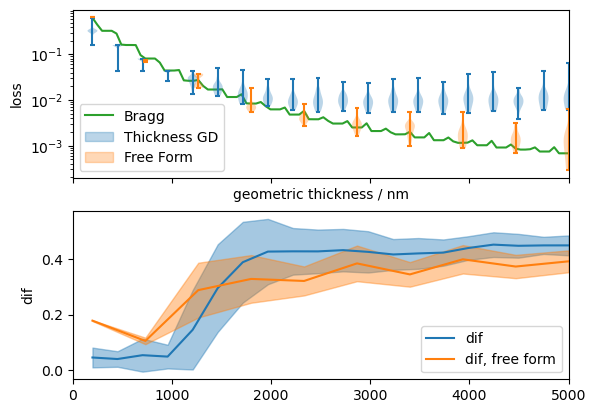

In [56]:
def plot():
    rep = 50
    gts = np.linspace(200, 5000, 20)
    gts_sp = np.linspace(200, 5000, 10)

    c_gen = color()

    fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)
    # thickness gd
    violin_handle_1 = plot_rep_violin(ax, gts, loss_rep_arr, 'Thickness GD')

    # DBR
    gts_dense = np.linspace(gts[0], gts[-1], 100)
    ax.plot(gts_dense, [loss_DBR(gt) for gt in gts_dense], label='Bragg', c='C2', zorder=0)
    # free form
    # plot_rep(
    #     ax, 
    #     np.array([films[-1].get_d().sum() for films in free_films_rep[0]]), 
    #     np.array([[min(l) for l in ls] for ls in free_losses_rep]), 
    #     'free_form'
    # )

    ax.set_ylabel('loss')
    auto_handles, _ = ax.get_legend_handles_labels()
    ax.legend(
        handles=auto_handles + [violin_handle_1], 
        loc='lower left'
    )
    ax.set_xlabel('geometric thickness / nm')
    ax.set_yscale('log')
    ax.set_xlim(0, 5000)
    # ax.set_ylim(1e-5, 1)



    c_gen = color()

    ax2 = plot_rep(ax2, gts, dif_gd, 'dif')
    ax2.set_ylabel('dif')
    ax2.legend(loc='lower right')

    # ax2.set_yscale('log')

with plt.style.context('bmh'):
    plot()

1.552480699243399